In [1]:
import sys
import os
sys.path.insert(0,"../")

from scipy.special import sph_harm
from scipy.integrate import quad, dblquad
from utils import lddmm_utils, mesh_processing, sph_utils, shape_stochastics
import open3d as o3d

import numpy as np
import trimesh as tri
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import pyssht

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
def get_data(file):
    mesh = o3d.io.read_triangle_mesh(file)
    V, F, Rho = mesh_processing.getDataFromMesh(mesh)
    return(V,F,Rho)

V,F,Rho = get_data("../data/test_data/bunny.ply")

sphere = tri.creation.uv_sphere(count=[32, 32])
mesh = tri.Trimesh(V,F)
new_mesh_V, new_mesh_F = mesh_processing.decimate_mesh(V,F,target = 1776)
new_mesh = tri.Trimesh(vertices = new_mesh_V, faces = new_mesh_F)

print("mesh: ", new_mesh_V[:,0].shape)
print("sphere: ", sphere.vertices.shape)

mesh:  (2016,)
sphere:  (2016, 3)


In [3]:
new_mesh_V[:,0] = (new_mesh_V[:,0] - new_mesh_V[:,0].mean()) / new_mesh_V[:,2].max(axis=0)
new_mesh_V[:,1] = (new_mesh_V[:,1] - new_mesh_V[:,1].mean()) / new_mesh_V[:,2].max(axis=0)
new_mesh_V[:,2] = (new_mesh_V[:,2] - new_mesh_V[:,2].mean()) / new_mesh_V[:,2].max(axis=0)

new_mesh = tri.Trimesh(vertices = new_mesh_V, faces = new_mesh_F)
(x_mesh, y_mesh, z_mesh) = new_mesh_V[:,0], new_mesh_V[:,1], new_mesh_V[:,2]

## Spherical parameterization of the bunny

In [4]:
(r_bunny, theta_bunny, phi_bunny) = pyssht.cart_to_spherical(x_mesh, y_mesh, z_mesh)
r_bunny_proj = np.divide(r_bunny, r_bunny)
x_mesh_proj, y_mesh_proj, z_mesh_proj = pyssht.spherical_to_cart(r_bunny_proj, theta_bunny, phi_bunny)

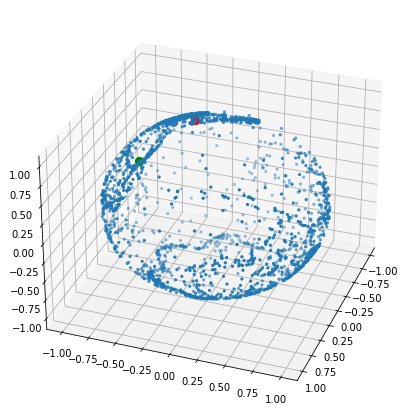

In [5]:
fig = plt.figure(figsize=(16,16))

ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(x_mesh_proj[1:], y_mesh_proj[1:], z_mesh_proj[1:], s = 5)
ax1.scatter(x_mesh_proj[0],y_mesh_proj[0],z_mesh_proj[0], s = 70, c='r')
ax1.scatter(x_mesh_proj[2],y_mesh_proj[2],z_mesh_proj[2], s = 70, c='g')
ax1.view_init(30, 20, 'y')

In [6]:
### Shape defined through 3 separated functions giving the xyz coordinates ###
def sphere_function_x(theta, phi):
    return np.sin(theta)*np.cos(phi)

def sphere_function_y(theta, phi):
    return np.sin(theta)*np.sin(phi)

def sphere_function_z(theta, phi):
    return np.cos(theta)

n = 25 #choose a resolution for the sph decomposition (HAS TO BE A SQUARED NUMBER FOR ISOTROPIC NOISE !!!)
Q = np.eye(n)
h, mu, sig = 1, 0, 0.1
b = lambda t, x : - h*(mu - x)
sigma = lambda t, x : sig

In [7]:
shape_stochastics.compute_diffusion_process_shape(x_mesh=x_mesh, y_mesh=y_mesh, z_mesh=z_mesh, faces=new_mesh_F, Q=Q, b=b, sigma=sigma,
                                               n = 25, t=1, n_step=20, make_gif=True, 
                                               file_dir = "tests/sde_process_bunny", file_name = "test.gif")

array([[[-0.11414345, -0.28782558, -0.65770418, ..., -0.05923923,
         -0.73639816, -0.74059403],
        [ 0.47267288,  0.50674384,  0.8698602 , ...,  0.90762816,
          0.85367393,  0.75430181],
        [-0.05910064, -0.09988711,  0.50695191, ..., -0.19318116,
         -0.8238307 , -0.36458139]],

       [[-0.11524352, -0.29682959, -0.67456157, ..., -0.05249571,
         -0.75342545, -0.76734492],
        [ 0.49894183,  0.54548641,  0.88636787, ...,  0.93514379,
          0.87838285,  0.80869981],
        [-0.08534469, -0.13923591,  0.53872284, ..., -0.22214297,
         -0.92451512, -0.42505125]],

       [[-0.13954802, -0.34048647, -0.74557682, ..., -0.07052288,
         -0.76689267, -0.81239945],
        [ 0.55934382,  0.62249842,  0.92118351, ...,  0.97242426,
          0.98315037,  0.884007  ],
        [-0.06701967, -0.12567703,  0.53435672, ..., -0.20605039,
         -0.88943578, -0.42443679]],

       ...,

       [[-0.56842586, -1.09199329, -1.14196387, ..., -0.3377810

In [7]:
### Compute the Q-Wiener process and output the list of meshes during the process and a .gif file 
sphere_diffusion_process = shape_stochastics.compute_diffusion_process(sphere_function_x, sphere_function_y, sphere_function_z,
                                         theta = theta_bunny, phi = phi_bunny, Q = Q, b = b, sigma = sigma, n = n, t=2, n_step=50, make_gif = False,
                                         file_dir = "tests/OU_process", file_name = "Q_identity_25coeffs.gif")

In [8]:
bunny_process = []
for step in sphere_diffusion_process:
    (r, theta_bunny, phi_bunny) = pyssht.cart_to_spherical(step[0], step[1], step[2])
    r = r - 1 + r_bunny
    (x_bunny, y_bunny, z_bunny) = pyssht.spherical_to_cart(r, theta_bunny, phi_bunny)
    bunny_process.append([x_bunny, y_bunny, z_bunny])
bunny_process = np.array(bunny_process)

In [9]:
import imageio
from matplotlib.collections import PolyCollection
import matplotlib.pyplot as plt
def create_gif(list_data, file_dir, file_name, auto_scale = True):
    filenames = []
    listpq = list_data
    steps = []
    #setting up the faces for the mesh
    rows_unique = np.unique(listpq[0,:,:].T, axis=0, return_index=True)
    new = listpq[0,:,:].T[rows_unique[1]]
    hull = tri.convex.convex_hull(new, qhull_options='QbB Pp Qt QJ')
    faces = new_mesh_F
    for i in range(listpq.shape[0]):
        steps.append(listpq[i,:,:].T[:])
    steps = np.array(steps)
    if not auto_scale:
        scale = np.max(steps[-1].max(0)-steps[-1].min(0))
    
    for i in range(len(listpq)):

        def frustum(left, right, bottom, top, znear, zfar):
            M = np.zeros((4, 4), dtype=np.float32)
            M[0, 0] = +2.0 * znear / (right - left)
            M[1, 1] = +2.0 * znear / (top - bottom)
            M[2, 2] = -(zfar + znear) / (zfar - znear)
            M[0, 2] = (right + left) / (right - left)
            M[2, 1] = (top + bottom) / (top - bottom)
            M[2, 3] = -2.0 * znear * zfar / (zfar - znear)
            M[3, 2] = -1.0
            return M
        def perspective(fovy, aspect, znear, zfar):
            h = np.tan(0.5*np.radians(fovy)) * znear
            w = h * aspect
            return frustum(-w, w, -h, h, znear, zfar)
        def translate(x, y, z):
            return np.array([[1, 0, 0, x], [0, 1, 0, y],
                         [0, 0, 1, z], [0, 0, 0, 1]], dtype=float)
        def xrotate(theta):
            t = np.pi * theta / 180
            c, s = np.cos(t), np.sin(t)
            return np.array([[1, 0,  0, 0], [0, c, -s, 0],
                         [0, s,  c, 0], [0, 0,  0, 1]], dtype=float)
        def yrotate(theta):
            t = np.pi * theta / 180
            c, s = np.cos(t), np.sin(t)
            return  np.array([[ c, 0, s, 0], [ 0, 1, 0, 0],
                          [-s, 0, c, 0], [ 0, 0, 0, 1]], dtype=float)

        def zrotate(theta):
            t = np.pi * theta / 180
            c, s = np.cos(t), np.sin(t)
            return  np.array([[ c, -s, 0, 0], [ s, c, 0, 0],
                          [0, 0, 1, 0], [ 0, 0, 0, 1]], dtype=float)

        V = np.array(steps[i])
        #V = np.array([it[:,0], it[:,1], it[:,2]]).T
        F = np.array([faces[:,0], faces[:,1], faces[:,2]]).T

        if auto_scale:
            V = (V-(V.max(0)+V.min(0))/2)/max(V.max(0)-V.min(0))
        else:
            V = (V-(V.max(0)+V.min(0))/2)/scale
        MVP = perspective(25,1,1,100) @ translate(0,0,-3.5) @ xrotate(20) @ yrotate(20) @ zrotate(-10) # for bunny @ xrotate(20) @ yrotate(20) @ zrotate(-10)
        V = np.c_[V, np.ones(len(V))]  @ MVP.T
        V /= V[:,3].reshape(-1,1)
        V = V[F]
        T =  V[:,:,:2]
        Z = -V[:,:,2].mean(axis=1)
        zmin, zmax = Z.min(), Z.max()
        Z = (Z-zmin)/(zmax-zmin)
        C = plt.get_cmap("magma")(Z)
        I = np.argsort(Z)
        T, C = T[I,:], C[I,:]
        fig = plt.figure(figsize=(6,6))
        ax = fig.add_axes([0,0,1,1], xlim=[-1,+1], ylim=[-1,+1], aspect=1, frameon=False)
        collection = PolyCollection(T, closed=True, linewidth=0.1, facecolor=C, edgecolor="black")
        ax.add_collection(collection)
    
        # create file name and append it to a list
        filename = f'{i}.png'
        filenames.append(filename)
    
        # last frame of each viz stays longer
        if (i == len(listpq)-1):
                for i in range(5):
                    filenames.append(filename)
    
        # save frame
        plt.savefig(filename, transparent=True)
        plt.close()# build gif
        
    if not os.path.exists(file_dir):
        os.makedirs(file_dir)
        
    images = []
    for filename in filenames:
        image = imageio.v3.imread(filename, plugin="pillow")
        images.append(image)
    imageio.v3.imwrite(os.path.join(file_dir,file_name), images, plugin="pillow", mode="RGBA", transparency=0, loop=0, disposal=2)
        
    # Remove files
    for filename in set(filenames):
        os.remove(filename)

In [10]:
create_gif(list_data = bunny_process, file_dir="tests/sde_process_bunny", file_name = "test.gif", auto_scale = True)

In [14]:
mesh_processing.create_gif_shape(list_data = bunny_process, faces = new_mesh_F, file_dir="tests", file_name = "test.gif")

In [15]:
shape_process = shape_stochastics.compute_wiener_process_shape(x_mesh=x_mesh, y_mesh=y_mesh, z_mesh=z_mesh, faces=new_mesh_F, Q=Q, n = 25, t=1, 
                                               n_step=20, make_gif=False, 
                                               file_dir = "tests/sde_process_shape", file_name = "test.gif")

In [17]:
mesh_processing.create_gif_shape(list_data = shape_process, faces = new_mesh_F, file_dir="tests", file_name = "test.gif")

In [42]:
h, mu, sig = 1, 0.5, 0.3
b = lambda t, x : - h*(mu - x)
sigma = lambda t, x : sig

In [43]:
from utils import brownian_motion
res = brownian_motion.Diffusion_process(b, sigma, 0).gen_traj(eta = 1, n_step = 100, T = 1)

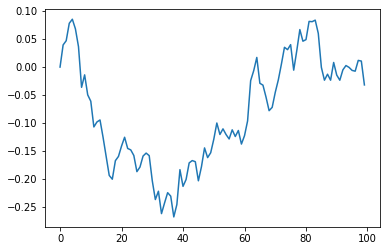

In [44]:
plt.plot(res)